### General imports and definitions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']

### First ideas:
- Try KMean and DBSCAN
- For each algorithm perform selection on the dataset and plot the results (use PCA to visualize clusters)
- Inject errors
- Try median/mode and MICE with K-NN with median/mode

### KMeans (for abalone.csv)

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer

In [3]:
# Load the dataset
df = pd.read_csv("../datasets/abalone.csv")
df

,0,1,2,3,4,5,6,7
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550
...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960


In [4]:
# Get one hot encoding of column 0
one_hot = pd.get_dummies(df['0'])
# Drop column 0 as it is now encoded
df_dropped = df.drop('0',axis = 1)

#X = df_dropped.join(one_hot)
X = df_dropped

Lets inspect the distribution between pairs of features

<Figure size 1000x1000 with 0 Axes>

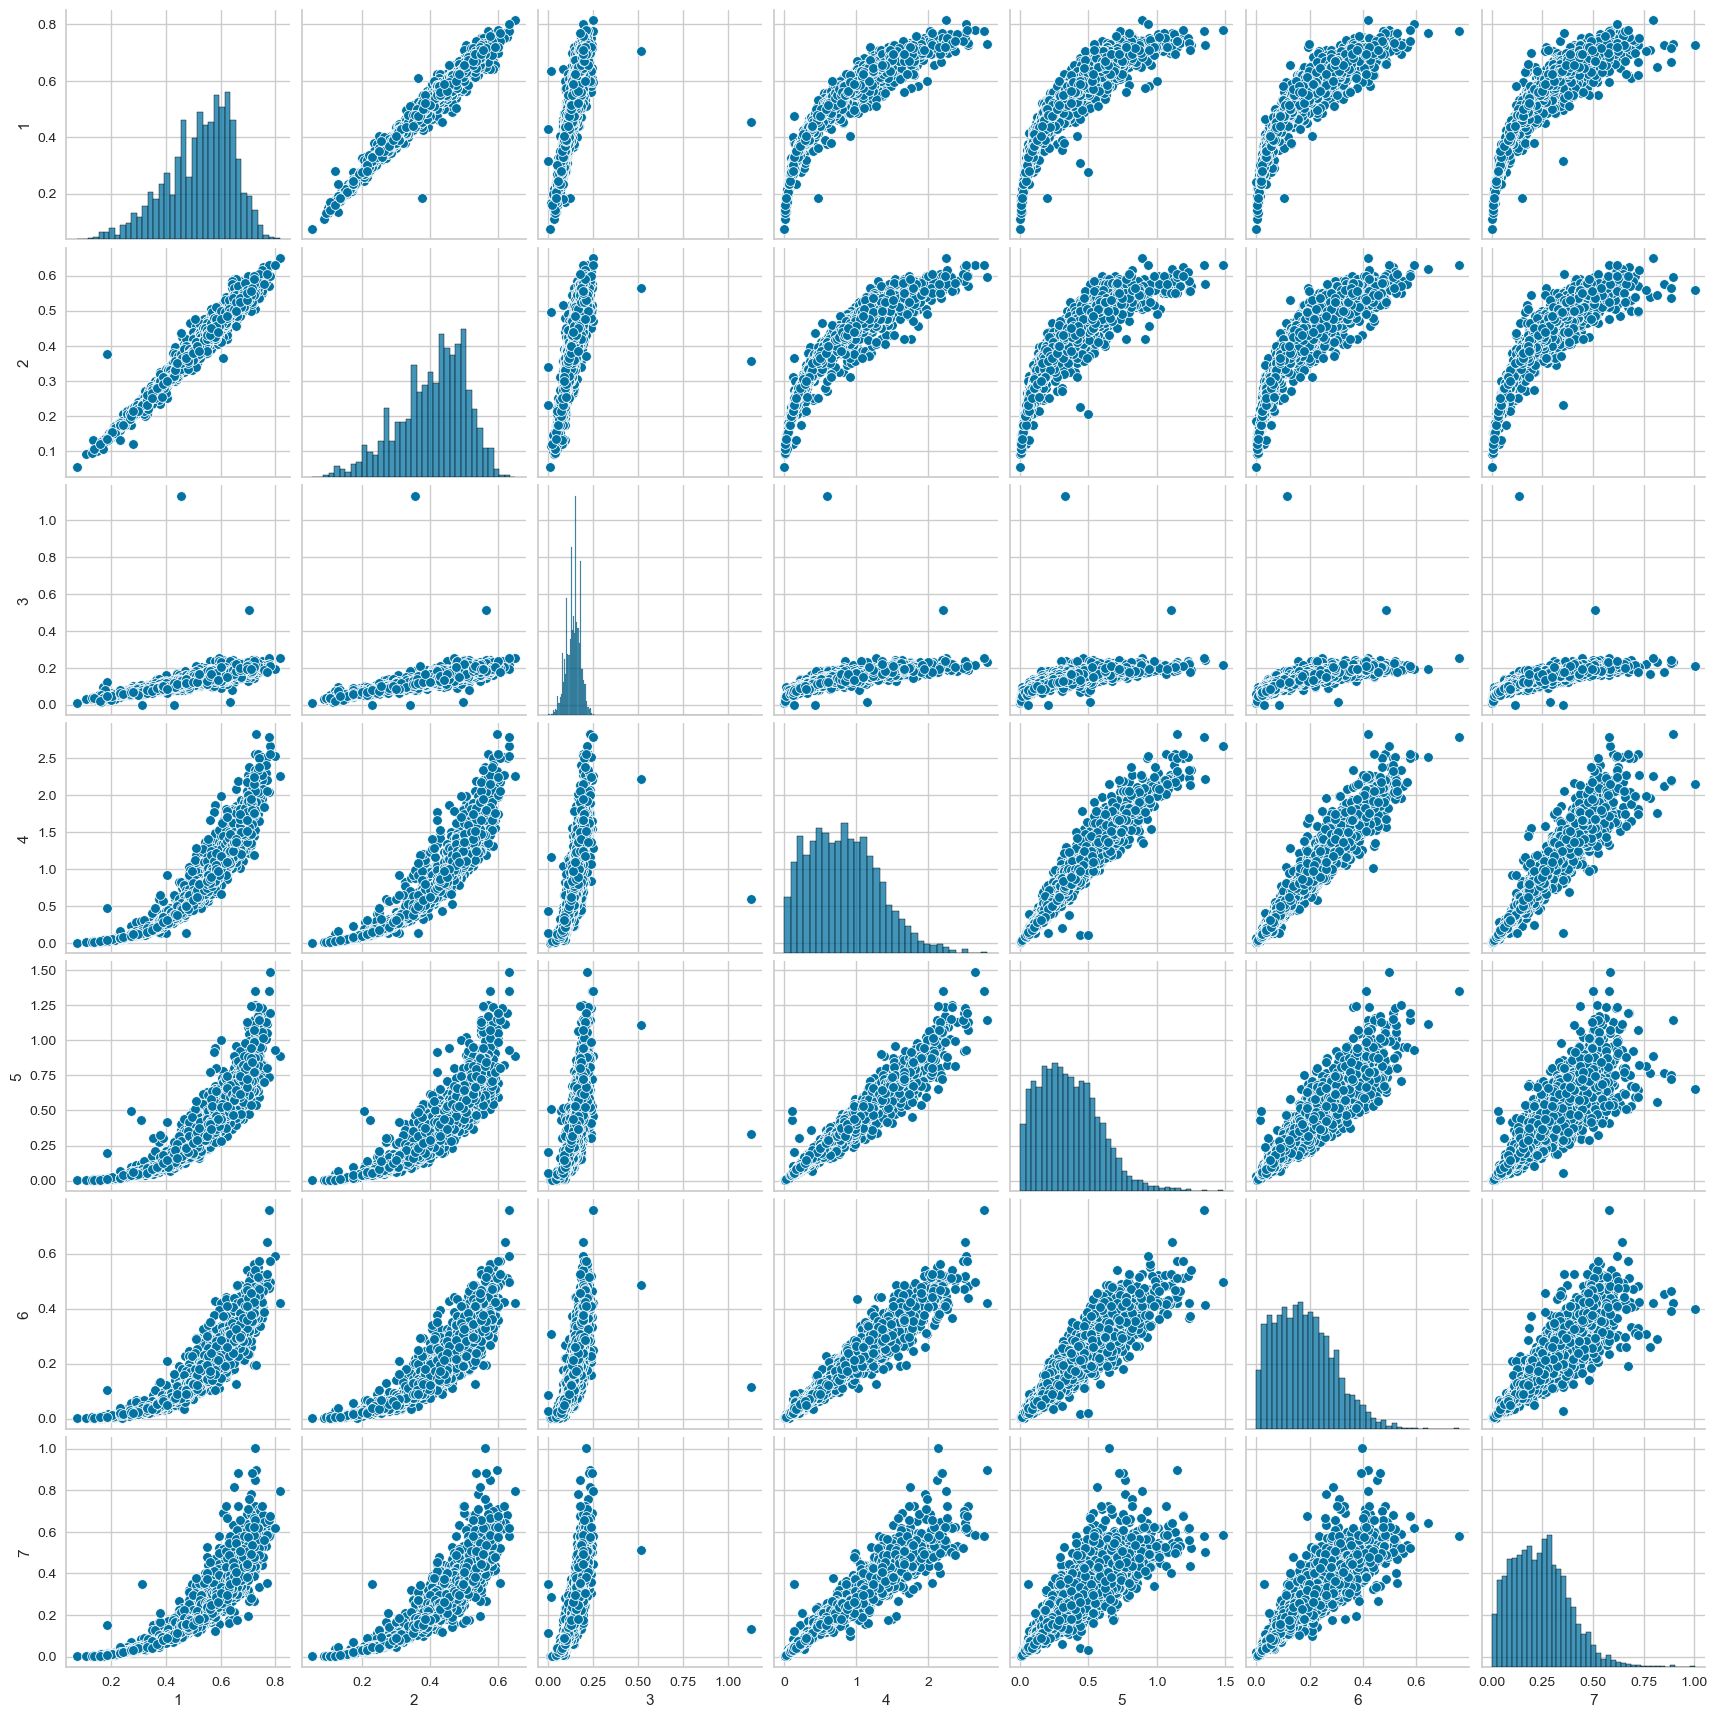

In [5]:
import seaborn as sns

plt.figure(figsize=(10,10))
sns.pairplot(df_dropped,
             diag_kind='hist',
             corner=False
            )

plt.show()

Visualization of the entire dataset performed through PCA reduction

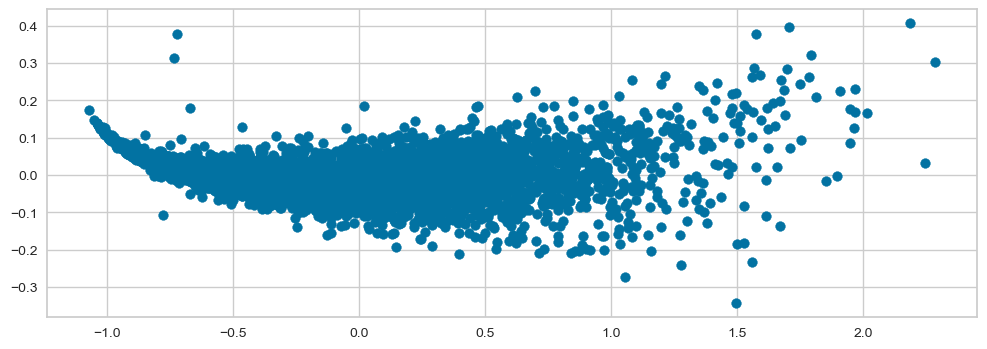

In [6]:
fig, ax = plt.subplots(figsize=(12,4))

pca = PCA(n_components=2,random_state=42)
X_pca = pca.fit_transform(X)

ax.scatter(X_pca[:, 0], X_pca[:, 1])

plt.show()

#### Searching the best value for k with the elbow method
We search for an elbow in the distortion score for different values of k

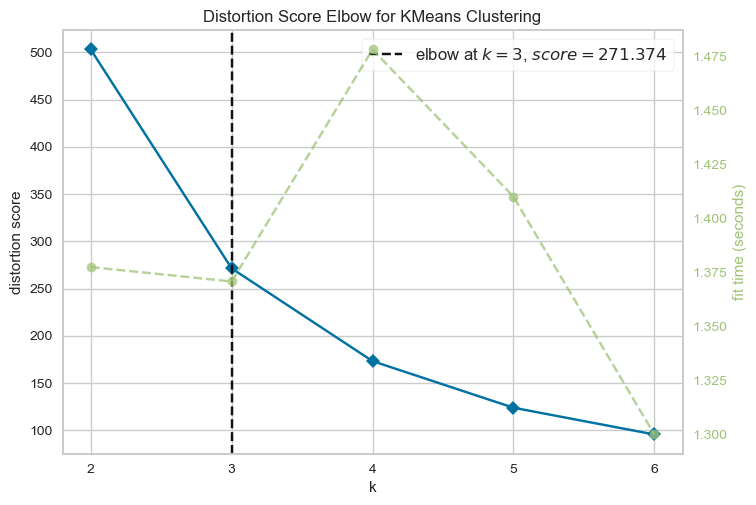

In [7]:
fig, ax = plt.subplots()

visualizer = KElbowVisualizer(KMeans(), k=(2,7),ax=ax)
visualizer.fit(X)
ax.set_xticks(range(2,7))

visualizer.show()
plt.show()

#### Searching the best value for k with silhouette scores
We search for the value of k that maximises the silhouette score of the found clusters

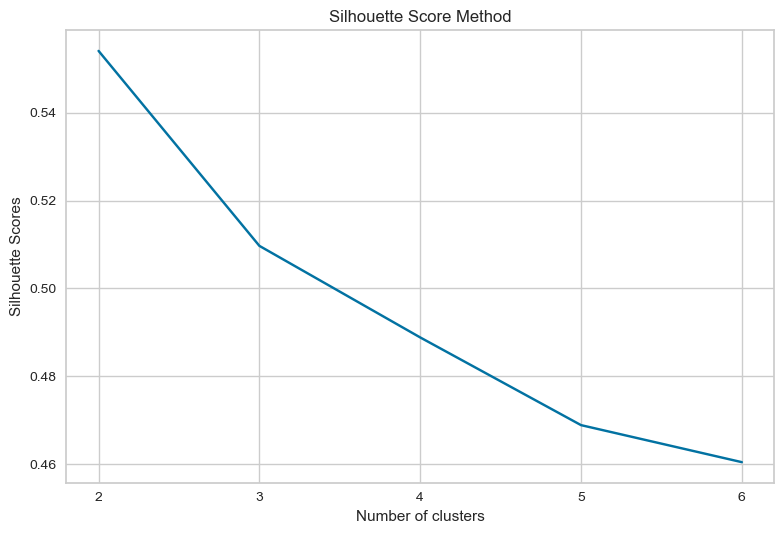

In [8]:
silhouette_scores = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, 
                max_iter=300, 
                tol=1e-04, 
                init='k-means++', 
                n_init=10, 
                random_state=42, 
                algorithm='lloyd')
    km.fit(X)
    silhouette_scores.append(silhouette_score(X, km.labels_))

fig, ax = plt.subplots()
ax.plot(range(2, 7), silhouette_scores, 'bx-')
ax.set_title('Silhouette Score Method')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Scores')
plt.xticks(range(2, 7))
plt.tight_layout()
plt.show()

#### Searching the best value for k with silhouette analysis
Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

We search for the value of k that generates clusters that are similar in size (width of the silhouette) and also in the distances between them (we want them to have average values near +1)

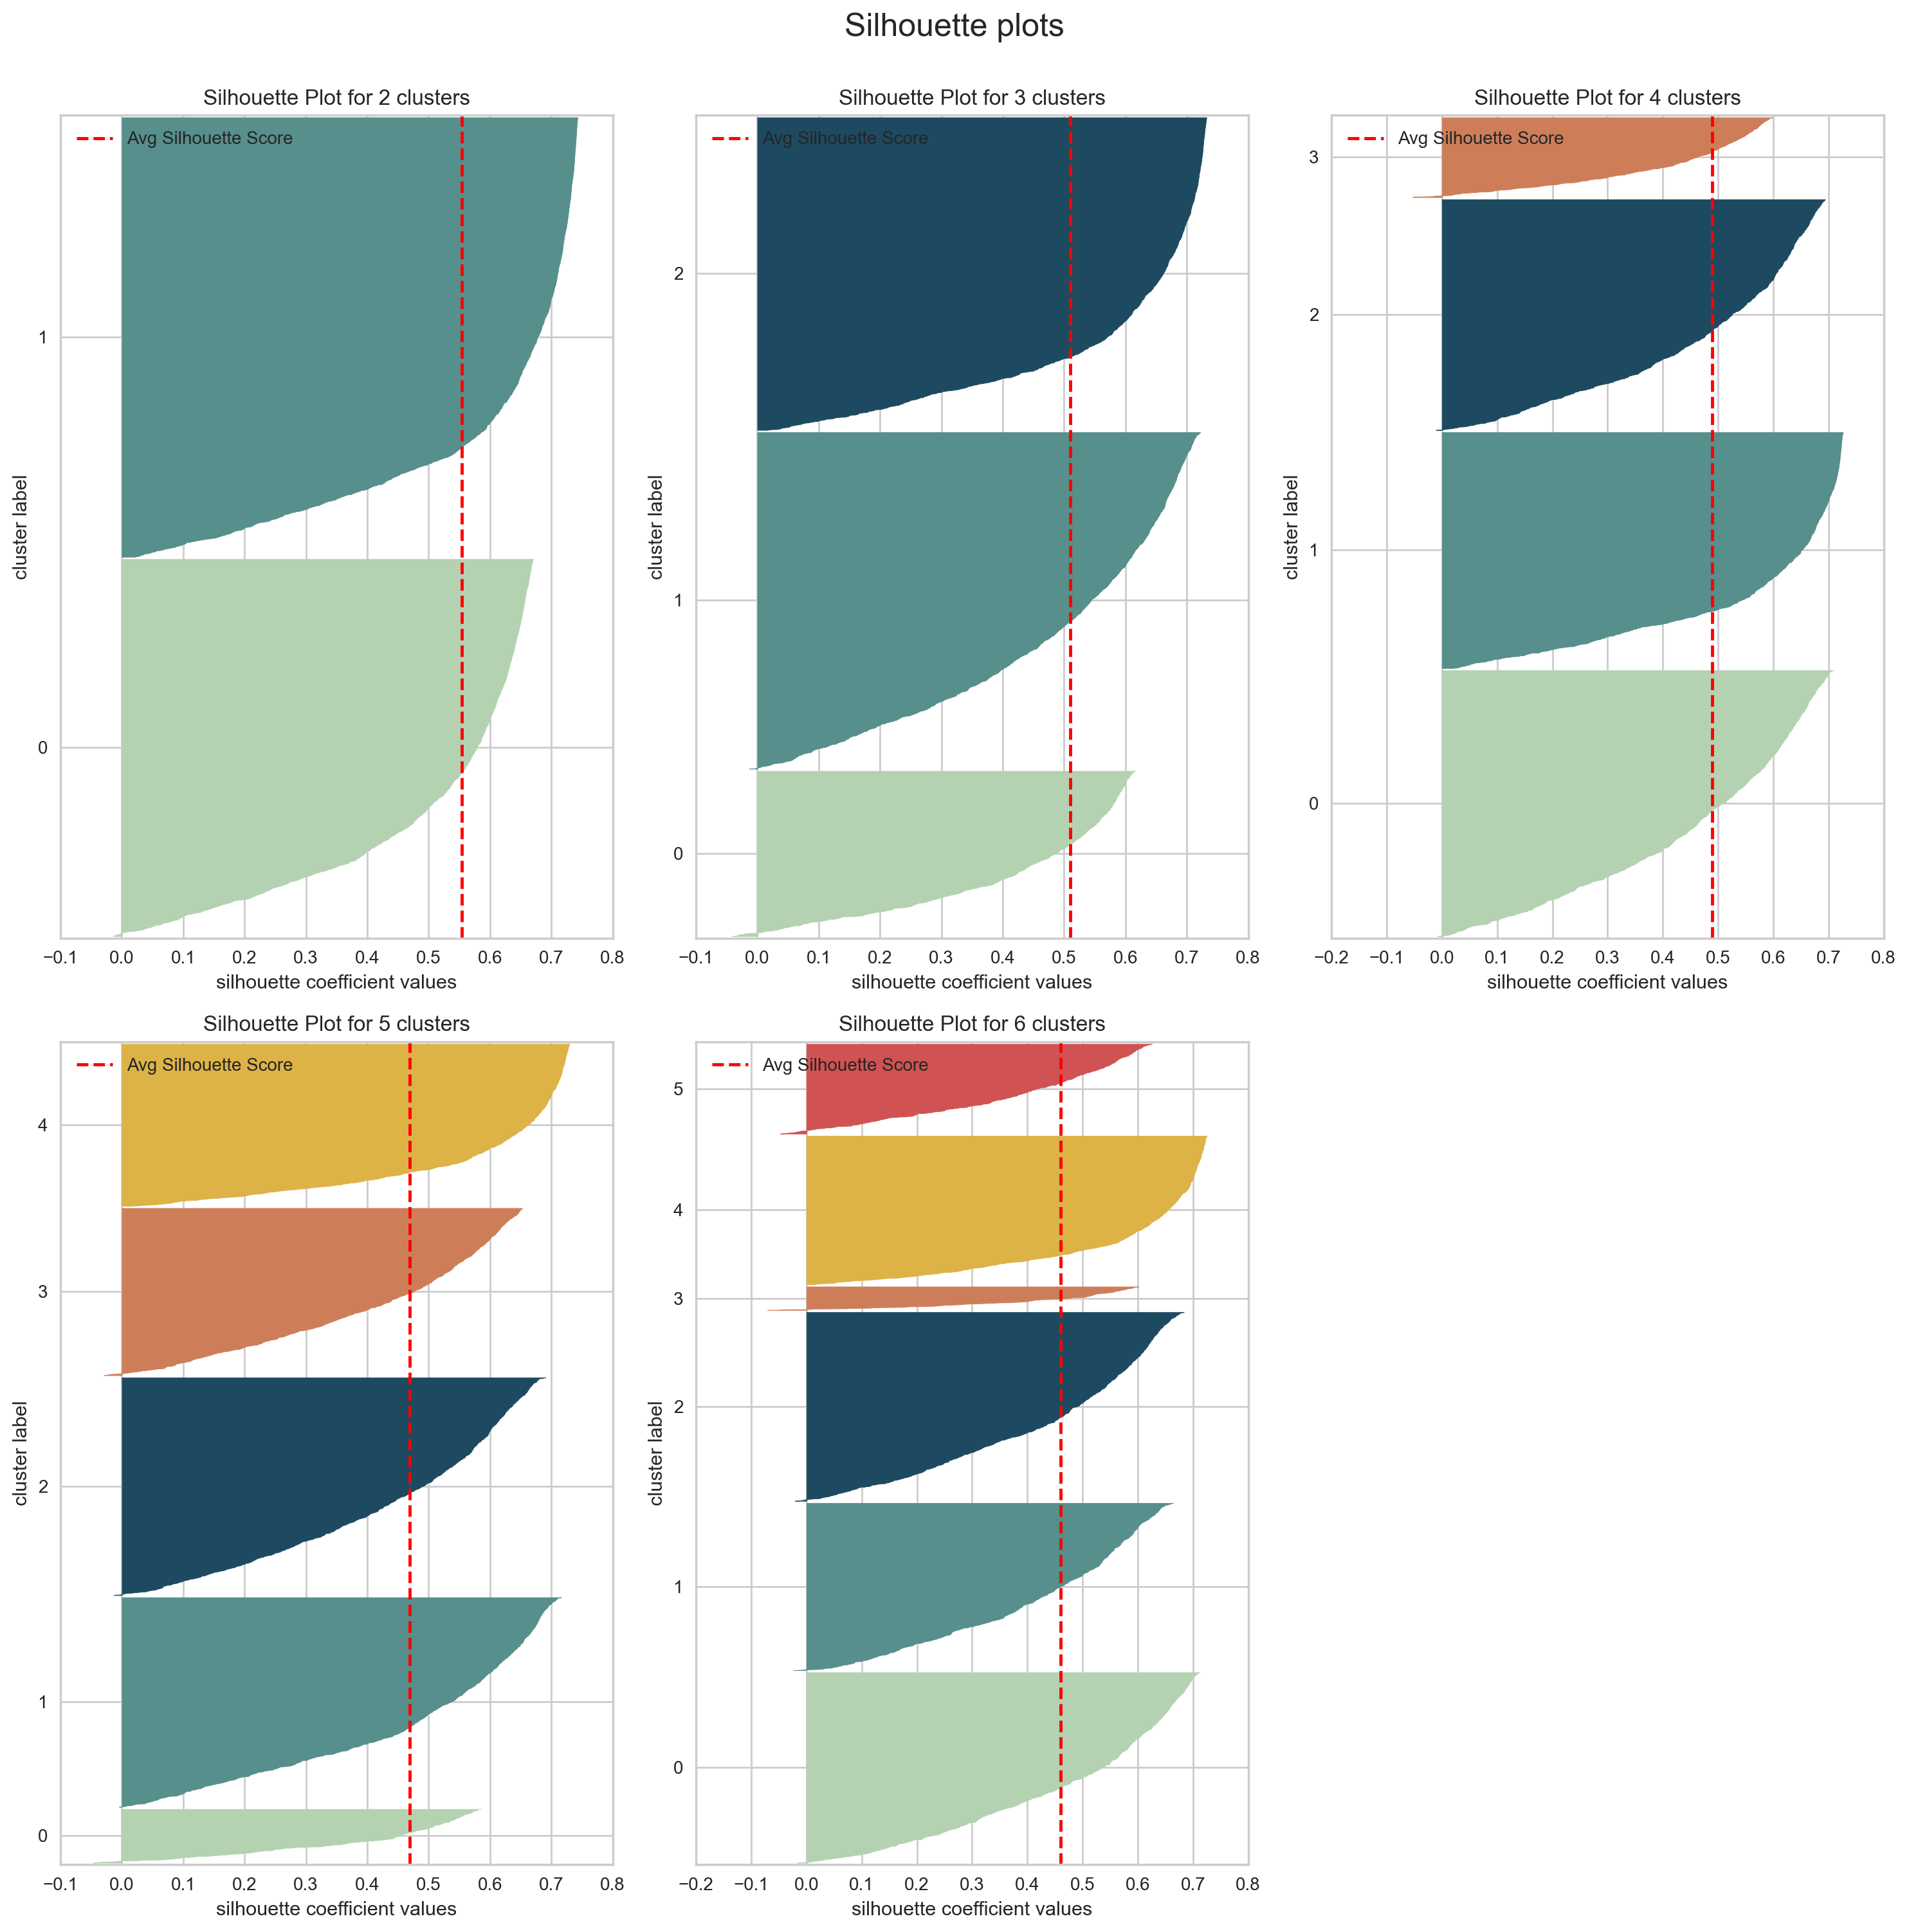

In [9]:
def silhouette_plot(X, model, ax, colors):
    y_lower = 10
    y_tick_pos_ = []
    sh_samples = silhouette_samples(X, model.labels_)
    sh_score = silhouette_score(X, model.labels_)
    
    for idx in range(model.n_clusters):
        values = sh_samples[model.labels_ == idx]
        values.sort()
        size = values.shape[0]
        y_upper = y_lower + size
        ax.fill_betweenx(np.arange(y_lower, y_upper),0,values,
                         facecolor=colors[idx],edgecolor=colors[idx]
        )
        y_tick_pos_.append(y_lower + 0.5 * size)
        y_lower = y_upper + 10

    ax.axvline(x=sh_score, color="red", linestyle="--", label="Avg Silhouette Score")
    ax.set_title("Silhouette Plot for {} clusters".format(model.n_clusters))
    l_xlim = max(-1, min(-0.1, round(min(sh_samples) - 0.1, 1)))
    u_xlim = min(1, round(max(sh_samples) + 0.1, 1))
    ax.set_xlim([l_xlim, u_xlim])
    ax.set_ylim([0, X.shape[0] + (model.n_clusters + 1) * 10])
    ax.set_xlabel("silhouette coefficient values")
    ax.set_ylabel("cluster label")
    ax.set_yticks(y_tick_pos_)
    ax.set_yticklabels(str(idx) for idx in range(model.n_clusters))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.legend(loc="best")
    return ax


# Plot for multiple ks
k_max = 6
ncols = 3
# calculate number of rows
nrows = k_max // ncols + (k_max % ncols > 0)
# set figure size
fig = plt.figure(figsize=(15,15), dpi=200)

for k in range(2,k_max+1):
    
    # Apply clustering for k clusters
    km = KMeans(n_clusters=k, 
                max_iter=300, 
                tol=1e-04, 
                init='k-means++', 
                n_init=10, 
                random_state=42, 
                algorithm='lloyd')

    km_fit = km.fit(X)
    
    # create chart
    ax = plt.subplot(nrows, ncols, k-1)
    silhouette_plot(X, km_fit,ax, cluster_colors)

fig.suptitle("Silhouette plots", fontsize=18, y=1)
plt.tight_layout()
plt.show()

#### Final decision

In [10]:
km = KMeans(n_clusters=3, 
            max_iter=300, 
            tol=1e-04, 
            init='k-means++', 
            n_init=10, 
            random_state=42, 
            algorithm='lloyd')

km_fit = km.fit(X)
y = km.fit_predict(X)
len(y)

4177

#### Visualize clusters
We'll apply PCA dimensionality reduction to map all of our records to 2-dimensional points of a scatter plot

array([[-0.37297053,  0.00140299],
       [-0.72693017,  0.02987049],
       [-0.17700541, -0.05958994],
       ...,
       [ 0.41895149,  0.01668526],
       [ 0.34791783,  0.02404874],
       [ 1.31843776,  0.13799284]])

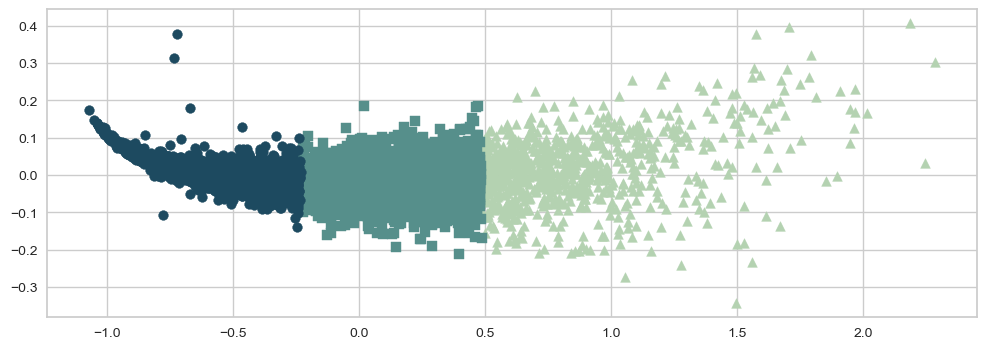

In [11]:
fig, ax = plt.subplots(figsize=(12,4))

pca_2 = PCA(n_components=2,random_state=42)
X_pca_2 = pca_2.fit_transform(X)
display(X_pca_2)

for l, c, m in zip(range(0, km_fit.n_clusters), cluster_colors[0:km_fit.n_clusters], ('^', 's', 'o')):
    ax.scatter(X_pca_2[y == l, 0],
                X_pca_2[y == l, 1],
                color=c,
                marker=m
                )

plt.show()

Lets try now with 3-dimensional points:

array([[-0.37297053,  0.00140299, -0.01135034],
       [-0.72693017,  0.02987049,  0.03463277],
       [-0.17700541, -0.05958994, -0.03216066],
       ...,
       [ 0.41895149,  0.01668526, -0.01313201],
       [ 0.34791783,  0.02404874, -0.06146214],
       [ 1.31843776,  0.13799284,  0.03434871]])

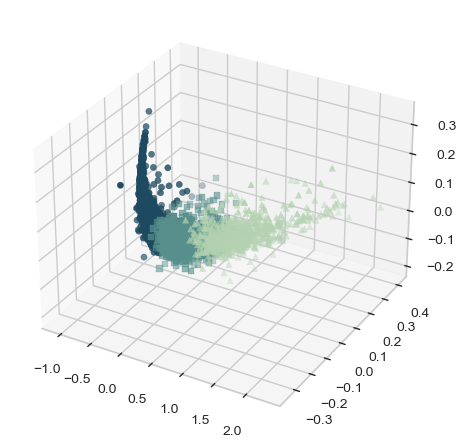

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

pca_3 = PCA(n_components=3,random_state=42)
X_pca_3 = pca_3.fit_transform(X)
display(X_pca_3)

for l, c, m in zip(range(0, km_fit.n_clusters), cluster_colors[0:km_fit.n_clusters], ('^', 's', 'o')):
    ax.scatter(X_pca_3[y == l, 0],
                X_pca_3[y == l, 1],
                X_pca_3[y == l, 2],
                color=c,
                marker=m
                )

plt.show()

### Problems
From the moment that in both of our datasets we have categorical features we understand that any clustering algorithm that uses the euclidean distances cannot work properly. More specifically:
- In abalone.csv we have both categorical and numerical features: if we try to remove the categorical ones by transforming them in one-hot encoded features we obtain 1 cluster for each value of these categorical features (probably because the one-hot encoded values are orthogonal between them and have norm = 1, a lot much w.r.t. the entities of the numerical values, projecting each tuple in some different hyperplanes that are so far between them that the algorithm is not able to distinguish anymore). For this reason we should initially try rescaling every feature and use KMeans on the new rescaled dataset, then try to use different algorithms like KModes and DBSCAN with Gower distance.
- In users.csv we only have categorical features: in this case we could try using one-hot encoding since in this way we would have all similar absolute values. If this does not give the hoped results we can still try the same algorithms as above. 

### First attempt: rescaling (standardization)

In [13]:
df = pd.read_csv("../datasets/abalone.csv")

one_hot = pd.get_dummies(df['0'])
df_dropped = df.drop('0',axis = 1)
X_no_std = df_dropped.join(one_hot)
X_no_std.describe()

,1,2,3,4,5,6,7,F,I,M
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,0.312904,0.321283,0.365813
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,0.463731,0.467025,0.481715
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,0.000000,0.000000,0.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,0.000000,0.000000,0.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,0.000000,0.000000,0.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,1.000000,1.000000,1.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,1.000000,1.000000,1.000000


In [14]:
from sklearn.preprocessing import StandardScaler

# Standardization
scaler = StandardScaler()
X = scaler.fit_transform(X_no_std)
# Since the fit_transform() strips the column headers
# we add them after the transformation
X = pd.DataFrame(X, columns=X_no_std.columns)
X.describe()

,1,2,3,4,5,6,7,F,I,M
count,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03
mean,-5.834718e-16,-3.027929e-16,3.912493e-16,9.185853e-17,-1.020650e-17,2.704723e-16,2.976897e-16,-4.252710e-17,-7.144552e-17,1.169495e-17
std,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00
min,-3.739154e+00,-3.556267e+00,-3.335953e+00,-1.686092e+00,-1.614731e+00,-1.643173e+00,-1.705134e+00,-6.748338e-01,-6.880179e-01,-7.594876e-01
25%,-6.161975e-01,-5.833158e-01,-5.862075e-01,-7.897577e-01,-7.811585e-01,-7.946415e-01,-7.819095e-01,-6.748338e-01,-6.880179e-01,-7.594876e-01
50%,1.749513e-01,1.725193e-01,1.156329e-02,-5.963767e-02,-1.052891e-01,-8.753202e-02,-3.470794e-02,-6.748338e-01,-6.880179e-01,-7.594876e-01
75%,7.579031e-01,7.267984e-01,6.093341e-01,6.613049e-01,6.426730e-01,6.606355e-01,6.478319e-01,1.481846e+00,1.453451e+00,1.316677e+00
max,2.423480e+00,2.440025e+00,2.368329e+01,4.072271e+00,5.085388e+00,5.286500e+00,5.504642e+00,1.481846e+00,1.453451e+00,1.316677e+00


Lets try to visualize the effects of this giving different colors basing on the value of the categorical feature

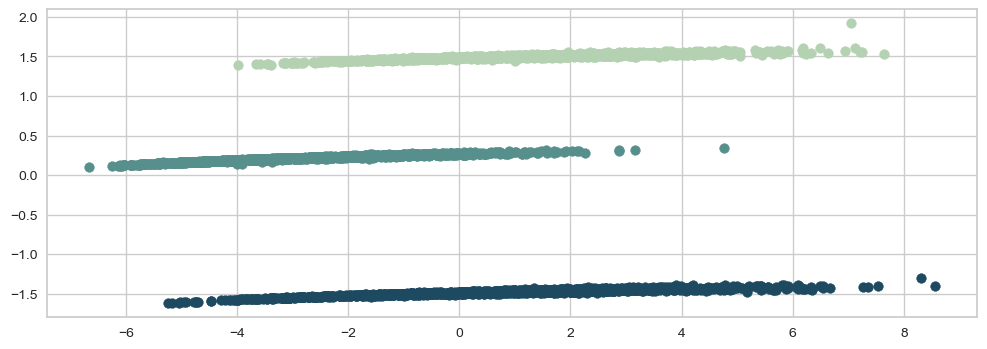

In [15]:
fig, ax = plt.subplots(figsize=(12,4))

pca = PCA(n_components=2,random_state=42)
X_pca = pca.fit_transform(X)

for l, c in zip(('F', 'I', 'M'), cluster_colors[:3]):
    ax.scatter(X_pca[df["0"] == l, 0], X_pca[df["0"] == l, 1], color=c)

plt.show()

We can easily see that standardization is not enough to cope with this effect: we need to try different algorithms

### Second attempt: use KPrototypes algorithm
KModes is used for clustering categorical variables. It defines clusters based on the number of matching categories between data points. (This is in contrast to the more well-known KMeans algorithm, which clusters numerical data based on Euclidean distance.) The KPrototypes algorithm combines KModes and KMeans and is able to cluster mixed numerical / categorical data.

In [16]:
df = pd.read_csv("../datasets/abalone.csv")

# Inspect the data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4177 non-null   object 
 1   1       4177 non-null   float64
 2   2       4177 non-null   float64
 3   3       4177 non-null   float64
 4   4       4177 non-null   float64
 5   5       4177 non-null   float64
 6   6       4177 non-null   float64
 7   7       4177 non-null   float64
dtypes: float64(7), object(1)
memory usage: 261.2+ KB


In [17]:
# Inspect the categorical variables
df.select_dtypes('object').nunique()

0    3
dtype: int64

In [18]:
from sklearn.preprocessing import StandardScaler

# Standardize numerical features only
df_dropped = df.drop('0',axis = 1)
scaler = StandardScaler()
X_num = scaler.fit_transform(df_dropped)
X_num = pd.DataFrame(X_num, columns=df_dropped.columns)
X_num.describe()

,1,2,3,4,5,6,7
count,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03,4.177000e+03
mean,-5.834718e-16,-3.027929e-16,3.912493e-16,9.185853e-17,-1.020650e-17,2.704723e-16,2.976897e-16
std,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00,1.000120e+00
min,-3.739154e+00,-3.556267e+00,-3.335953e+00,-1.686092e+00,-1.614731e+00,-1.643173e+00,-1.705134e+00
25%,-6.161975e-01,-5.833158e-01,-5.862075e-01,-7.897577e-01,-7.811585e-01,-7.946415e-01,-7.819095e-01
50%,1.749513e-01,1.725193e-01,1.156329e-02,-5.963767e-02,-1.052891e-01,-8.753202e-02,-3.470794e-02
75%,7.579031e-01,7.267984e-01,6.093341e-01,6.613049e-01,6.426730e-01,6.606355e-01,6.478319e-01
max,2.423480e+00,2.440025e+00,2.368329e+01,4.072271e+00,5.085388e+00,5.286500e+00,5.504642e+00


In [19]:
# Recompose the dataset
X = pd.concat([df["0"], X_num], axis=1)

# Get the position of categorical columns
catColumnsPos = [X.columns.get_loc(col) for col in list(X.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(X.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

X

Categorical columns           : ['0']
Categorical columns position  : [0]


,0,1,2,3,4,5,6,7
0,M,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217
1,M,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987
2,F,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139
3,M,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294
4,I,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757
...,...,...,...,...,...,...,...,...
4172,F,0.341509,0.424464,0.609334,0.118813,0.047908,0.532900,0.073062
4173,M,0.549706,0.323686,-0.107991,0.279929,0.358808,0.309362,0.155685
4174,M,0.632985,0.676409,1.565767,0.708212,0.748559,0.975413,0.496955
4175,F,0.841182,0.777187,0.250672,0.541998,0.773341,0.733627,0.410739


In [20]:
# Convert dataframe to matrix
dfMatrix = X.to_numpy()
dfMatrix

array([['M', -0.5745581331424137, -0.4321487936470637, ...,
        -0.6076853645006243, -0.7262115735818162, -0.6382168891980078],
       ['M', -1.4489858478494209, -1.4399289969040678, ...,
        -1.1709098401337676, -1.205221240836591, -1.2129873174176684],
       ['F', 0.05003309164830575, 0.12213031814428864, ...,
        -0.46349989873853953, -0.35668983027099027, -0.2071390680332622],
       ...,
       ['M', 0.6329849014529767, 0.676409429935641, ...,
        0.7485591728239849, 0.9754132443803829, 0.49695470653582224],
       ['F', 0.8411819763832166, 0.7771874502613415, ...,
        0.7733410497518435, 0.733627412337497, 0.41073914230287306],
       ['M', 1.5490520311460314, 1.4826335925412453, ...,
        2.6409934109513467, 1.787448680298001, 1.8404805824992794]],
      dtype=object)

Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6


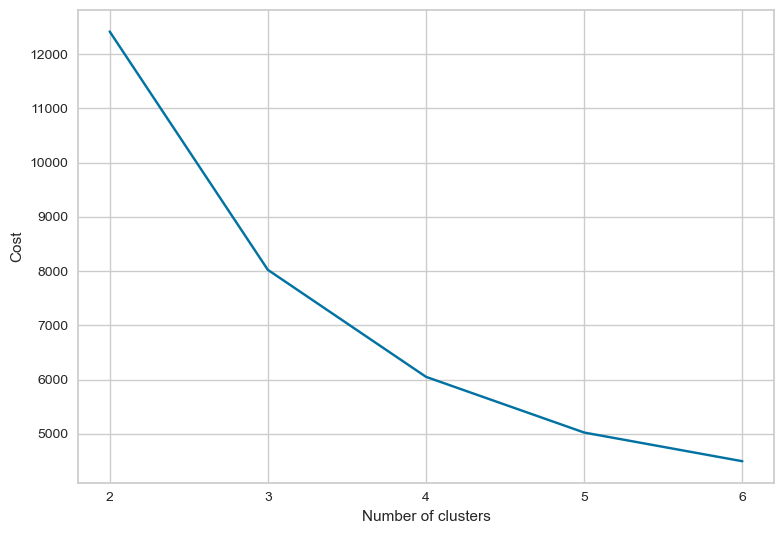

In [21]:
from kmodes.kprototypes import KPrototypes

# Choose optimal K using Elbow method
cost = []
for cluster in range(2, 7):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except Exception as e: 
        print(e)

fig, ax = plt.subplots()
ax.plot(range(2, 7), cost)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Cost')
plt.xticks(range(2, 7))
plt.tight_layout()
plt.show()

We decide to go for k = 3

In [22]:
k = 3

# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = k, init = 'Huang', random_state = 0)
kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
len(kprototype.labels_)

4177

Centroids interpretation

In [23]:
# Add the cluster to the dataframe
X['Cluster Labels'] = kprototype.labels_
X['Segment'] = X['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third'})
# Order the cluster
X['Segment'] = X['Segment'].astype('category')
X['Segment'] = X['Segment'].cat.reorder_categories(['First','Second','Third'])

# Cluster interpretation
X.groupby('Segment').agg(
    {
        'Cluster Labels':'count',
        '1': 'mean',
        '2': 'mean',
        '3': 'mean',
        '4': 'mean',
        '5': 'mean',
        '6': 'mean',
        '7': 'mean',
        '0': pd.Series.mode,
    }
).reset_index()

,Segment,Cluster Labels,1,2,3,4,5,6,7,0
0,First,1262,-1.227690,-1.229269,-1.069729,-1.111289,-1.064053,-1.089888,-1.096015,I
1,Second,1135,1.068016,1.072152,1.006233,1.272729,1.233929,1.254744,1.217399,F
2,Third,1780,0.189408,0.187891,0.116811,-0.023652,-0.032402,-0.027357,0.000799,M


Check: lets see the number of tuples per each value of the categorical feature

In [24]:
df.groupby('0').size()

0
F    1307
I    1342
M    1528
dtype: int64

Good! Cluster division does not correspond to the categorical division. Lets visualize now the final result with PCA

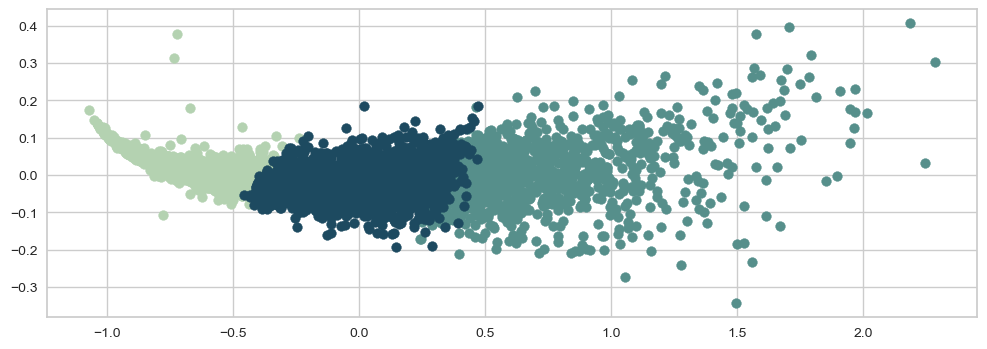

In [25]:
fig, ax = plt.subplots(figsize=(12,4))

pca = PCA(n_components=2,random_state=42)
X_pca = pca.fit_transform(df_dropped)

for l, c in zip(range(k), cluster_colors[:k]):
    ax.scatter(X_pca[X['Cluster Labels'] == l, 0], X_pca[X['Cluster Labels'] == l, 1], color=c)

plt.show()

### DBSCAN (for abalone.csv)

In [26]:
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("../datasets/abalone.csv")
df_dropped = df.drop('0',axis = 1)
scaler = StandardScaler()
X_num = scaler.fit_transform(df_dropped)
X_num = pd.DataFrame(X_num, columns=df_dropped.columns)
X_all = pd.concat([df["0"], X_num], axis=1)
X_all

,0,1,2,3,4,5,6,7
0,M,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217
1,M,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987
2,F,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139
3,M,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294
4,I,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757
...,...,...,...,...,...,...,...,...
4172,F,0.341509,0.424464,0.609334,0.118813,0.047908,0.532900,0.073062
4173,M,0.549706,0.323686,-0.107991,0.279929,0.358808,0.309362,0.155685
4174,M,0.632985,0.676409,1.565767,0.708212,0.748559,0.975413,0.496955
4175,F,0.841182,0.777187,0.250672,0.541998,0.773341,0.733627,0.410739


Since we need to handle categorical data we'll use a different distance metrice, the Gower distance

In [27]:
import gower

X = gower.gower_matrix(X_all)

Let's visualize it

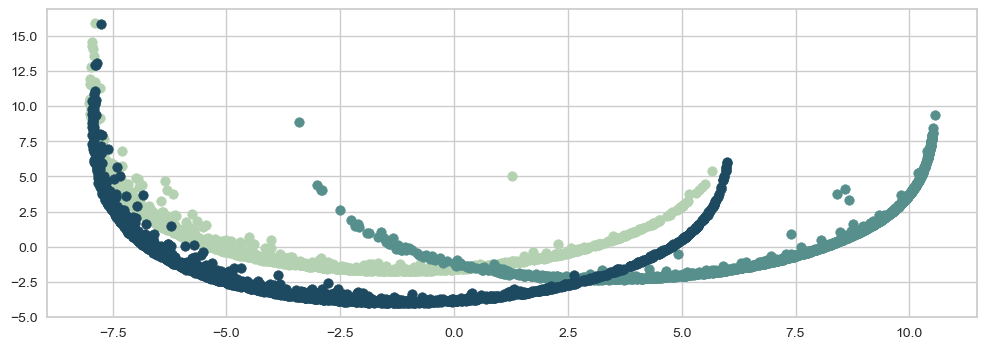

In [28]:
fig, ax = plt.subplots(figsize=(12,4))

pca = PCA(n_components=2,random_state=42)
X_pca = pca.fit_transform(X)

for l, c in zip(('F', 'I', 'M'), cluster_colors[:3]):
    ax.scatter(X_pca[df["0"] == l, 0], X_pca[df["0"] == l, 1], color=c)

plt.show()

Lets find a way to systematically tune the 2 parameters of DBSCAN: eps (the radius of the circle that is used to understand the role of each sample) and min_samples (the minimum number of neighbors that a point has to have inside its neighboring circle of radius eps to be considered a core point, [see algorithm description](https://youtu.be/dQw4w9WgXcQ))

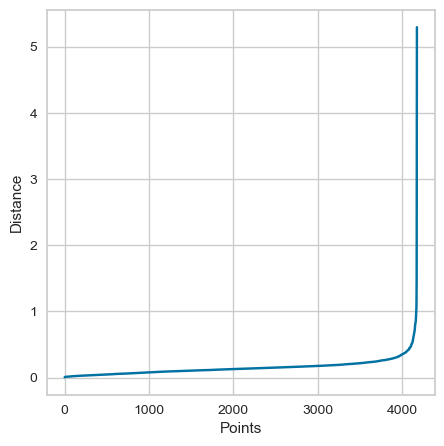

In [29]:
from sklearn.neighbors import NearestNeighbors

min_samples = 2  # should depend on the dataset
nearest_neighbors = NearestNeighbors(n_neighbors=min_samples) 
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances[:, min_samples - 1], axis=0)

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()

We need to locate the elbow of this curve

0.25390318

<Figure size 500x500 with 0 Axes>

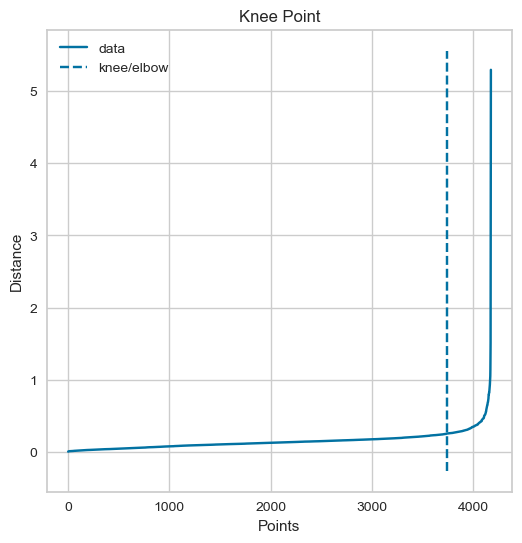

In [30]:
from kneed import KneeLocator

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

eps = distances[knee.knee]
eps

We can now try to fit our DBSCAN model

In [35]:
from sklearn.cluster import DBSCAN

#db = DBSCAN(eps = eps, min_samples = min_samples, metric = "precomputed").fit(X)
db = DBSCAN(eps = 0.1, min_samples = 5, metric = "precomputed").fit(X)
X_all['Cluster Labels'] = db.labels_

# Check how many clusters we have identified
labels = X_all['Cluster Labels'].unique()
labels

array([ 0,  1,  2, -1], dtype=int64)

Lets visualize the final result

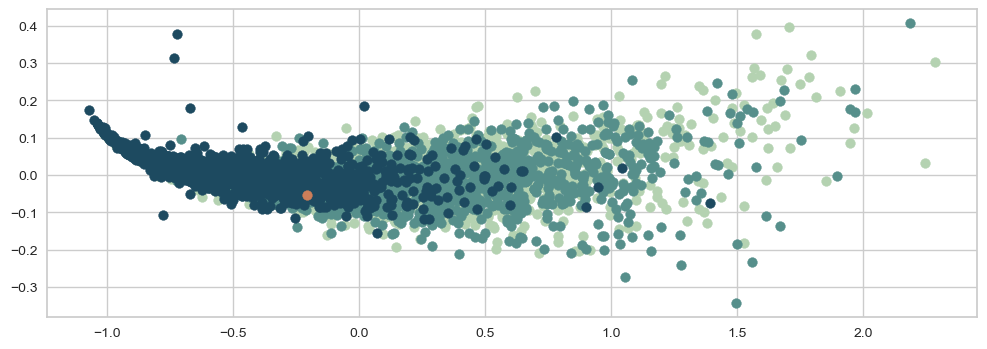

In [36]:
fig, ax = plt.subplots(figsize=(12,4))

pca = PCA(n_components=2,random_state=42)
X_pca = pca.fit_transform(df_dropped)

for l, c in zip(labels, cluster_colors[:len(labels)]):
    ax.scatter(X_pca[X_all['Cluster Labels'] == l, 0], X_pca[X_all['Cluster Labels'] == l, 1], color=c)

plt.show()

On the gower distance matrix

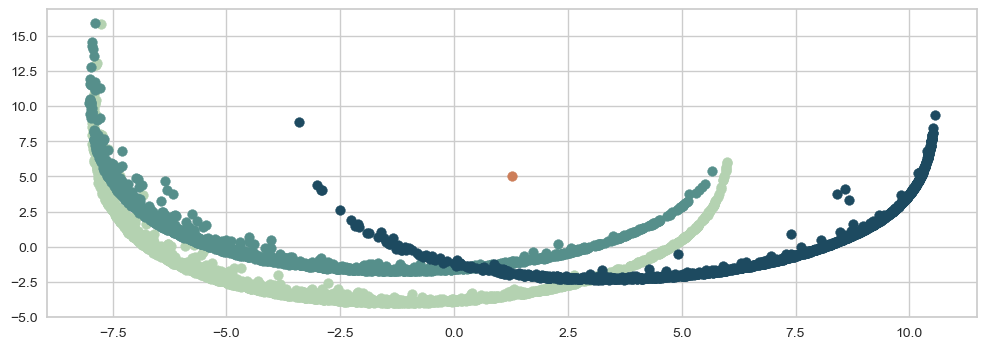

In [37]:
fig, ax = plt.subplots(figsize=(12,4))

pca = PCA(n_components=2,random_state=42)
X_pca = pca.fit_transform(X)

for l, c in zip(labels, cluster_colors[:len(labels)]):
    ax.scatter(X_pca[X_all['Cluster Labels'] == l, 0], X_pca[X_all['Cluster Labels'] == l, 1], color=c)

plt.show()